In [ ]:
from dotenv import load_dotenv
from textwrap import dedent     # tap(들여쓰기)에 상관없이 쓸 수 있게.
from pprint import pprint
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import TypedDict
from typing import Literal
import os
load_dotenv()

True

# 임베딩 및 크로마 DB 로드

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

menu_db = Chroma(
    embedding_function=embeddings_model,
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


# tool 선언 (Search_Menu)

In [3]:
from langchain_core.tools import tool
from typing import List

@tool
def search_menu(query: str) -> List[str]:
    # llm이 이정보를 참조해서 검색 성능을 향상 시킴.
    """
    레스토랑 메뉴에서 정보를 검색합니다.
    """
    
    docs = menu_db.similarity_search(query, k=2)
    formatted_docs = "\n---\n".join([
        f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
        for doc in docs
        ])
       
    if len(formatted_docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."
    

# Web Search (덕덕고 사용)

In [32]:
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

@tool
def search_web(query: str) -> str:
    """
    데이터 베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷으로 검색합니다.
    """
    wrapper = DuckDuckGoSearchAPIWrapper()
    # list[dict] 구조 보장. 각 항목 키: link, title, snippet
    results = wrapper.results(query, max_results=3)
    
    formatted_docs = "\n---\n".join([
        f'<Document href="{r.get("link", "")}"/>\n{r.get("snippet", "")}\n</Document>'
        for r in results if isinstance(r, dict)
        ])
       
    if len(formatted_docs) > 0:
        return formatted_docs
    return "관련 정보를 찾을 수 없습니다."

# OpenAI 가져오기

In [33]:
from langchain_openai import ChatOpenAI
# llm 선언
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
# tool 등록 (def)
tools = [search_menu, search_web]
llm_with_tools = llm.bind_tools(tools=tools)

# tool_call 확인 로그

In [34]:
from langchain_core.messages import AIMessage, HumanMessage

tool_call = llm_with_tools.invoke([HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")])
print(tool_call)

content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_pFcdrsFGzJSLMJdBR8M2Vy1u', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c'} id='run--9f0e9345-e425-479e-9fae-b297c95ae9c6-0' tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_pFcdrsFGzJSLMJdBR8M2Vy1u', 'type': 'tool_call'}]


# 도구노드 (Tool Node) : 
### LLM이 요청한 (tool) 호출을 실행하는 역할을 처리

In [35]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools)

# tool_call 로그 확인

In [36]:
tool_call = llm_with_tools.invoke([HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_T0bxyWDOa6Niy6FeDxmYiG1J', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c'}, id='run--987e75da-631e-47f2-af03-5d71729ed29a-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_T0bxyWDOa6Niy6FeDxmYiG1J', 'type': 'tool_call'}])

# tool_node 로그 확인

In [37]:
results = tool_node.invoke({"messages":[tool_call]})
results

c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\chromadb\types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\chromadb\types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x


{'messages': [ToolMessage(content='<Document href="./data/restaurant_menu.txt"/>\n8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.\n</Document>\n---\n<Document href="./data/restaurant_menu.txt"/>\n7. 랍스터 비스크\n   • 가격: ₩28,000\n   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카\n   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.\n</Document>', name='search_menu', tool_call_id='call_T0bxyWDOa6Niy6FeDxmYiG1J')]}

# tool_node 내부 컨텐츠 확인

In [38]:
for result in results["messages"]:
    print(result.content)
    print()

<Document href="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>
---
<Document href="./data/restaurant_menu.txt"/>
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>



# create_react_agent 사용

In [39]:
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    model=llm,      # tool을 갖지 않은 순혈 llm
    tools=tools
)

# 그래프 시각화

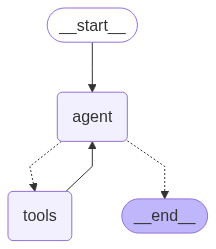

In [40]:
display(Image(graph.get_graph().draw_mermaid_png()))

# input(query)에 대해서 tools 호출에 대한 판단의 과정 로그로 보기

In [41]:
inputs = {
    "messages":[
        HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")
    ]
}
messages = graph.invoke(inputs)
for message in messages["messages"]:
    message.pretty_print()

c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\chromadb\types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\chromadb\types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x


================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_vWseIlPMQSRjSX1VvsXNKoAJ)
 Call ID: call_vWseIlPMQSRjSX1VvsXNKoAJ
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>
---
<Document href="./data/restaurant_menu.txt"/>
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>
================================== Ai Message ==================================

스테이크 메뉴의 가격은 다음

# 노드 선언(GraphState)

In [42]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import  AIMessage, HumanMessage, SystemMessage

class GraphState(MessagesState):
    pass

# 시스템 프롬포트

In [43]:
system_prompt = dedent("""
You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크
    
    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니다...

    Action: search_web
    Action Input: History of AI

    (After receiving tool output)
    [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
    AI의 역사는 다음과 같이 요약됩니다...

If tool use is not necessary, answer directly.

Your final answer should be clear, concise, and directly related to the user's question. 
Ensure that every piece of factual information in your response is accompanied by a citation.

Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
Do not provide any information without a corresponding citation.
""")

# 노드 불러오는 함수 선언

In [44]:
def call_node(state: GraphState) -> GraphState:
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    
    return {"messages":[response]}

# 노드에 대해 call_back 분기 여부 함수 선언

In [45]:
def should_continue(state: GraphState):
    last_message = state['messages'][-1]
    if last_message.tool_calls:     # 마지막 답변에 tool_calls가 있을때의 조건
        return "excute_tools"       # 임의로 정한 변수명
    return END

# 그래프 만들기

In [46]:
builder = StateGraph(GraphState)
# 노드 추가
builder.add_node("call_node", call_node)
builder.add_node("excute_tools", ToolNode(tools=tools))
# 엣지 순서도
builder.add_edge(START, "call_node")
builder.add_conditional_edges(
    "call_node",
    should_continue,
    {
        "excute_tools": "excute_tools",
        END: END
    }
)
builder.add_edge("excute_tools", "call_node")

graph = builder.compile()


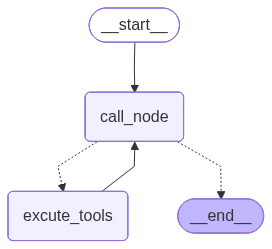

In [47]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
inputs = {
    "messages":[
        # HumanMessage("스테이크 메뉴의 가격은 얼마인가요?")
        HumanMessage("랭그래프는 뭔가요?")
    ]
}
messages = graph.invoke(inputs)
for message in messages["messages"]:
    message.pretty_print()

c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


================================ Human Message =================================

랭그래프는 뭔가요?
================================== Ai Message ==================================
Tool Calls:
  search_web (call_oDuldPSxNsLFiY23F5mSzvoa)
 Call ID: call_oDuldPSxNsLFiY23F5mSzvoa
  Args:
    query: 랭그래프란 무엇인가
================================= Tool Message =================================
Name: search_web

<Document href="https://blog.naver.com/codenit/223986891696"/>
Aug 28, 2025 · 1. 랭그래프란 무엇인가? 최근 AI 학습과 실무 활용 과정에서 가장 많이 언급되는 기술 중 하나가 바로 랭그래프 (LangGraph)입니다. 이름만 들으면 생소할 수 있지만 간단히 …
</Document>
---
<Document href="https://ai-inform.tistory.com/entry/랭그래프란-LangGraph-쉬운설명"/>
Feb 21, 2025 · 인공지능 (AI) 랭그래프란? LangGraph 쉬운설명 by 뉴디라 2025. 2. 21.
</Document>
---
<Document href="https://www.php.cn/faq/1796694007.html"/>
Nov 24, 2024 · What is LangGraph? LangGraph is a workflow orchestration framework designed specifically for LLM …
</Document>
================================== Ai Message =============

In [50]:
inputs = {
    "messages":[
        HumanMessage("파스타에 어울리는 음료는 뭔가요?")
    ]
}
messages = graph.invoke(inputs)
for message in messages["messages"]:
    message.pretty_print()

c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\chromadb\types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\chromadb\types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed

================================ Human Message =================================

파스타에 어울리는 음료는 뭔가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_WPWT0kwrVfE4V3nt1LfSkm37)
 Call ID: call_WPWT0kwrVfE4V3nt1LfSkm37
  Args:
    query: 파스타 음료
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>
---
<Document href="./data/restaurant_menu.txt"/>
4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝 뿌려 고급스러운 향을 더했습니다. 파슬리를 곱게 다져 고명으로 올려 제공됩니다.
</Document>
================================== Ai Message =================================

# 랭그래프 히스토리 남기기

In [51]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_memory = builder.compile(checkpointer=memory)

# 메모리 세이버가 알 수 있게 세션값 지정

In [60]:
config = {"configurable":{"thread_id":"1"}}

inputs = {
    "messages":[
        HumanMessage("파스타에 어울리는 음료는 뭔가요? 검색조건은 기존 db 검색과 웹 검색 두가지 모두 알려주세요")
    ]
}
messages = graph_memory.invoke(inputs, config)
for message in messages["messages"]:
    message.pretty_print()

c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\chromadb\types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works

================================ Human Message =================================

파스타에 어울리는 음료는 뭔가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_vfBLXMsaRtle4FwWHBOFzHjH)
 Call ID: call_vfBLXMsaRtle4FwWHBOFzHjH
  Args:
    query: 파스타 음료
  search_web (call_DTZVZwA1fT54O10BZXoQbgnP)
 Call ID: call_DTZVZwA1fT54O10BZXoQbgnP
  Args:
    query: 음식과 어울리는 음료
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>
---
<Document href="./data/restaurant_menu.txt"/>
4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝 뿌려 고급스러운 향을 더했습니다. 파

In [63]:
config = {"configurable":{"thread_id":"1"}}

inputs = {
    "messages":[
        HumanMessage("방금 말했던 것 중 저렴한 음료는 무엇인가요? 검색조건 동일하게 해주세요")
    ]
}
messages = graph_memory.invoke(inputs, config)
for message in messages["messages"]:
    message.pretty_print()

c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\chromadb\types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\chromadb\types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x


================================ Human Message =================================

파스타에 어울리는 음료는 뭔가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_vfBLXMsaRtle4FwWHBOFzHjH)
 Call ID: call_vfBLXMsaRtle4FwWHBOFzHjH
  Args:
    query: 파스타 음료
  search_web (call_DTZVZwA1fT54O10BZXoQbgnP)
 Call ID: call_DTZVZwA1fT54O10BZXoQbgnP
  Args:
    query: 음식과 어울리는 음료
================================= Tool Message =================================
Name: search_menu

<Document href="./data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>
---
<Document href="./data/restaurant_menu.txt"/>
4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝 뿌려 고급스러운 향을 더했습니다. 파

# 챗봇 구현

In [64]:
import gradio as gr
from typing import List, Tuple
import uuid


memory = MemorySaver()

graph_memory = builder.compile(checkpointer=memory)

example_questions = [
    "채식주의자를 위한 메뉴를 추천해 주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "파스타에 어울리는 음료는 무엇인가요?"
]

# 챗봇 답변 메시지 처리를 위한 함수
def process_message(message: str, history: List[Tuple[str, str]], thread_id: str) -> str:
    try:
        config = {"configurable": {"thread_id": thread_id}}
        inputs = {"messages": [HumanMessage(content=message)]}
        
        result = graph_memory.invoke(inputs, config)
        
        if "messages" in result:
            last_message = result["messages"][-1]
            if isinstance(last_message, AIMessage):
                return last_message.content
            
        return "응답을 처리하는 데 문제가 발생했습니다."
    except Exception as e:
        return f"오류가 발생했습니다: {str(e)}"
    
    
class Chatbot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        response = process_message(message, history, self.thread_id)        #
        return response
        
chatbot = Chatbot()

demo = gr.ChatInterface(
    fn=chatbot.chat,
    examples=example_questions,
    title="LangGraph 챗봇",
    description="레스토랑 메뉴에 대한 질문을 해보세요.",
    theme=gr.themes.Soft(),
)

demo.launch()

c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\gradio\routes.py:63: PendingDeprecationWarning: Please use `import python_multipart` instead.
  from multipart.multipart import parse_options_header
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\gradio\routes.py:1215: DeprecationWarning: 
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
  @app.on_event("startup")
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualen

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\starlette\templating.py:162: DeprecationWarning: The `name` is not the first parameter anymore. The first parameter should be the `Request` instance.
Replace `TemplateResponse(name, {"request": request})` by `TemplateResponse(request, name)`.
  warnings.warn(
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\starlette\templating.py:162: DeprecationWarning: The `name` is not the first parameter anymore. The first parameter should be the `Request` instance.
Replace `TemplateResponse(name, {"request": request})` by `TemplateResponse(request, name)`.
  warnings.warn(
c:\Users\scv31\AppData\Local\pypoetry\Cache\virtualenvs\langgraph-works-VZ1_LVEb-py3.11\Lib\site-packages\chromadb\types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute

In [65]:
demo.close()

Closing server running on port: 7860
